# Inferencing output image by using pre-trained Model

In [1]:
import os, torch, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm 

from torch.utils.data import Dataset, DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
# 체크포인트 경로 및 체크포인트 파일 확인
chk_dir = '/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint'
chk_file = os.path.join(chk_dir, 'model_epoch.pth')

In [4]:
print(os.path.exists(chk_dir))
print(chk_dir)
print(chk_file)

True
/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint
/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/checkpoint/model_epoch.pth


## Create Dataset and Dataloader for TestModel.

## Create Test Model(with checkpoint file)

In [5]:
# https://pypi.org/project/segmentation-models-pytorch/
!pip install -q segmentation-models-pytorch
!pip install -q albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.5 MB/s eta 0:00:00


In [6]:
import segmentation_models_pytorch as smp
from albumentations import Compose, Normalize
from albumentations.pytorch import ToTensorV2

In [ ]:
# define model and load pre-trained model.
model = smp.Unet(encoder_name="resnet18", encoder_weights=None, classes=4, activation=None)
model.to(device)
dict_model = torch.load(f=chk_file, map_location=torch.device(device))  # keys for dict : 'net', 'optim'

model.load_state_dict(dict_model['net'])
model.eval()

데이터 셋을 만들기 전에 이미지 한 개로 모델 테스트를 해보자.

In [8]:
data_dir = '/content/drive/MyDrive/CV_Projects/pytorch_steelDefect/datasets'
data_test = os.path.join(data_dir, 'test_images')
fnames = os.listdir(data_test)

In [9]:
len(fnames)

5506

In [10]:
input = cv2.imread(os.path.join(data_test, fnames[99]))

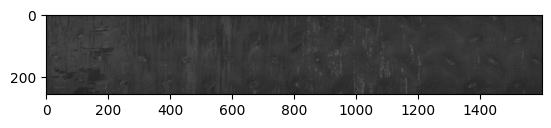

In [11]:
plt.imshow(input)

In [12]:
mean = (0.485, 0.456, 0.406)
std =  (0.229, 0.224, 0.225)
# transform function and apply it.
list_transforms = [Normalize(mean=mean, std=std, p=1), ToTensorV2()]
transforms = Compose(list_transforms)

In [13]:
input_t = transforms(image=input)
input_t = input_t['image'].to(device)

if input_t.ndim == 3:
  input_t = input_t.unsqueeze(dim=0)
  print(input_t.shape)  # (batch_size, channel, width, height)

torch.Size([1, 3, 256, 1600])


In [14]:
output_t = model(input_t)
output_t = torch.sigmoid(output_t)

In [15]:
# make tensor to numpy
output_n = output_t.detach().cpu().numpy()

In [16]:
# I transformed output data into numpy-shape(n,w,h,c),
# but, in order to loop data by each channel, i do not need to transpose this array data.
# output_n = output_n.transpose(0,2,3,1)
output_n.shape

(1, 4, 256, 1600)

In [17]:
print(type(output_n))
print(output_n.max())

<class 'numpy.ndarray'>
0.1479106


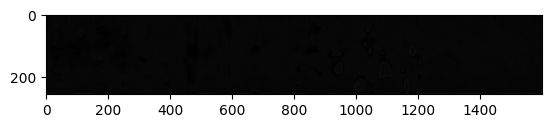

In [18]:
plt.imshow(output_n[0][0], cmap='gray')

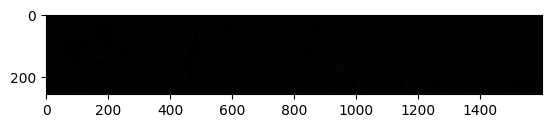

In [19]:
plt.imshow(output_n[0][1], cmap='gray')

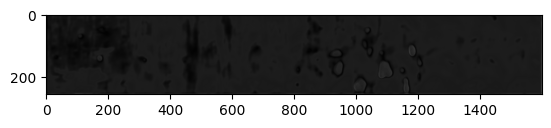

In [20]:
plt.imshow(output_n[0][2], cmap='gray')

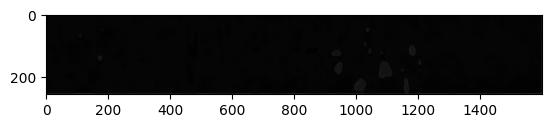

In [21]:
plt.imshow(output_n[0][3], cmap='gray')

(array([1.21367e+05, 2.85507e+05, 1.94100e+03, 5.32000e+02, 2.13000e+02,
        3.80000e+01, 0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00]),
 array([0.00835104, 0.022307  , 0.03626295, 0.05021891, 0.06417486,
        0.07813082, 0.09208678, 0.10604273, 0.11999869, 0.13395464,
        0.14791059]),
 <BarContainer object of 10 artists>)

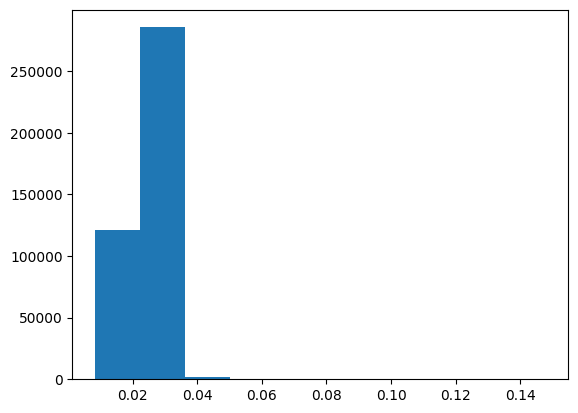

In [22]:
plt.hist(output_n[0][2].ravel())

In [23]:
fn_class = lambda x: (x>0.09) * 1
output_n_class = fn_class(output_n)

In [24]:
output_n_class[0][2].max()

1

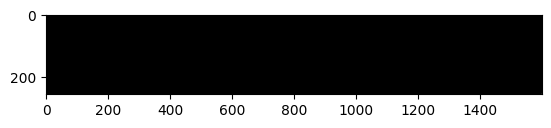

In [25]:
plt.imshow(output_n_class[0][2], cmap='gray')

## Mask to RLE

In [26]:
mask1 = output_n_class[0][0].T.flatten()
mask2 = output_n_class[0][1].T.flatten()
mask3 = output_n_class[0][2].T.flatten()
mask4 = output_n_class[0][3].T.flatten()

In [27]:
key, cnt = np.unique(mask3, return_counts=True)

In [28]:
dict(zip(key, cnt))

{0: 409598, 1: 2}

In [29]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
a

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [30]:
a_T = a.T
a_T

array([[1, 4, 7],
       [2, 5, 8],
       [3, 6, 9]])

In [31]:
a_flat = a.flatten()
a_T_flat = a.T.flatten()

In [32]:
a_flat

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [33]:
a_T_flat

array([1, 4, 7, 2, 5, 8, 3, 6, 9])

T 를 사용한 후 flatten 을 걸어주는 이유를 여기서 확인할 수 있다. 행 방향 순서대로 요소를 하나씩 인덱싱 하는 방식(포트란)을 사용하기 때문에, transpose 를 먼저 수행 한 후 mask 작업을 해준다.

In [34]:
# np.concatenate 사용법
a = np.array([1,2,3,4,5])
a

array([1, 2, 3, 4, 5])

In [35]:
a = np.concatenate([[0],a,[9999]])
a

array([   0,    1,    2,    3,    4,    5, 9999])

In [36]:
# bit 연산을 이용? 해서 자릿수가 다른 위치를 찾아간다.
mask3 = np.concatenate([[0],mask3, [0]])

In [37]:
print(mask3[1:].shape)
mask3[1:]

(409601,)


array([0, 0, 0, ..., 0, 1, 0])

In [38]:
print(mask3[:-1].shape)
mask3[:-1]

(409601,)


array([0, 0, 0, ..., 0, 0, 1])

In [39]:
tmp = np.where(mask3[1:] != mask3[:-1])[0]
tmp

array([409344, 409345, 409599, 409600])

In [40]:
runs = tmp + 1
runs

array([409345, 409346, 409600, 409601])

In [41]:
# position index : starting
print(runs[::2])
# position index : ending, (reference for length value)
print(runs[1::2])

[409345 409600]
[409346 409601]


In [42]:
# get length value by subtraction
runs[1::2] = runs[1::2] - runs[::2]
print(runs)

[409345      1 409600      1]


check rle data with flatten array.

In [43]:
strtmp = ' '.join(str(run) for run in runs)
strtmp

'409345 1 409600 1'

Define as a function.

In [44]:
def mask2rle(img):
  mask = img.T.flatten()
  mask = np.concatenate([[0],mask,[0]])

  runs = np.where(mask[:-1]!=mask[1:])[0] + 1   # find the index of different digit between 0 and 1
  runs[1::2] = runs[1::2] - runs[:-1:2]         # update length value

  # make into string data.
  return ' '.join(str(run) for run in runs)

In [45]:
rle1 = mask2rle(mask1)
rle2 = mask2rle(mask2)
rle3 = mask2rle(mask3)
rle4 = mask2rle(mask4)

In [46]:
df_submit = pd.read_csv(os.path.join(data_dir,'sample_submission.csv'))
len(df_submit['ImageId'])

5506

In [47]:
class TestDataset(Dataset):
  def __init__(self, root, df, mean, std):
    self.root = root
    # in case of multiple fnames are exits, Counting only once when it comes to same file name.
    self.fnames = df['ImageId'].unique().tolist() 
    self.num_samples = len(self.fnames)
    self.transform = Compose([
        Normalize(mean=mean, std=std, p=1),
        ToTensorV2()
    ])

  def __getitem__(self, idx):
    '''
      idx : among self.fnames
    '''
    fname = self.fnames[idx]
    path = os.path.join(self.root, fname)
    img = cv2.imread(path)

    # transform
    img = self.transform(image=img)['image']
    
    return fname, img

  def __len__(self):
    return self.num_samples


In [48]:
batch_size = 4
num_workers = 2

testDataset = TestDataset(root=data_test, df=df_submit, mean=mean, std=std)
dataLoader = DataLoader(dataset=testDataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [49]:
# just for checking batch data.
# for fnames, imgs in dataLoader:
#   print('filename : ', fnames)
#   print('| imgs shape : ', imgs.shape)

In [50]:
prediction = []
prediction.append(['ddd.jpg','1 2 3 4 5 5 6 6 0'])
prediction.append(['bdd.jpg','0 2 3 4 5 5 6 6 0'])
prediction

[['ddd.jpg', '1 2 3 4 5 5 6 6 0'], ['bdd.jpg', '0 2 3 4 5 5 6 6 0']]

In [51]:
columns = ['ImageId_ClassId','EncodedPixels']

In [52]:
# prediction = []

# for i, batch in enumerate(tqdm(dataLoader)):
#   fnames, imgs = batch
#   batch_outputs = torch.sigmoid(model(imgs.to(device)))
#   batch_outputs = batch_outputs.detach().cpu().numpy()
#   for fname, oneBatch in zip(fnames, batch_outputs):
#     for cls, oneMaskImg in enumerate(oneBatch):   # oneMaskImg --> one Channel mask img.
#       # (todo) need to post processing...
#       rle = mask2rle(oneMaskImg)
#       name = fname + f'_{cls+1}'
#       prediction.append([name, rle])

In [53]:
# save data into dataframe
df = pd.DataFrame(prediction, columns=columns)
df.to_csv('submission.csv', index=False)

In [54]:
!ls

drive  sample_data  submission.csv


## Understanding and adding post processing function.

In [175]:
# set parameters
best_threshold = 0.08
min_size = 100

In [176]:
# get temp batch data for testing...
data_t = testDataset.__getitem__(199)[1] # index=0 >> fname. 1 >> img data
data_t = data_t.unsqueeze(dim=0)
print(data_t.shape)  # (n, c, w, h)

torch.Size([1, 3, 256, 1600])


In [ ]:
# get inferenced img data.
output_t = torch.sigmoid(model(data_t.to(device)))
output_n = output_t.detach().cpu().numpy()
output_n

In [178]:
print(output_n.shape)
print(type(output_n))
output_n = output_n[0]
print(output_n.shape)

(1, 4, 256, 1600)
<class 'numpy.ndarray'>


In [180]:
# get third channel of the img as mask data.
mask = cv2.threshold(output_n[2], best_threshold, 1, cv2.THRESH_BINARY)[1]
mask.mean()

0.0032763672

In [181]:

num_comps, comps = cv2.connectedComponents(mask.astype(np.uint8))
print(num_comps)
print(comps.shape)

11
(256, 1600)


In [182]:
# check labeled pixel numbers with each labled pixel value.
for i in range(1, num_comps): # in case of 0, excluding because of black pixel.
  p = (comps == i)
  print(p.sum())

1
11
256
12
7
6
5
16
503
525


In [183]:
predictions = np.zeros((comps.shape[0], comps.shape[1]), np.float32)
print(predictions.mean())
predictions

0.0


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [184]:
# for example, if it is for component(labeled) 3.
p = (comps == 3)
print(p.sum())    # the number of true values in each pixel.
print(p.shape)
print(type(p))
p

256
(256, 1600)
<class 'numpy.ndarray'>


array([[False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       ...,
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True],
       [False, False, False, ..., False, False,  True]])

I can find the value marked as True means it has labeled with specific component number.

In [185]:
predictions[p] = 1    # set pixel value as 1 where found component pixels.
print(predictions.mean())
predictions

0.000625


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## It converted to specified value(1) when put a ndarray which has boolean data type into target array.

In [210]:
def post_process(pred, best_threshold, min_size):
  '''
    parameters
      pred           : one channel output img.
      best_threshold : threshold value for making binary img(0 and 1)
      min_size       : min size of total pixel values 

    return
      predictions    : 
      num            : 
  '''
  mask = cv2.threshold(pred, best_threshold, 1, cv2.THRESH_BINARY)[1]
  num_comps, component = cv2.connectedComponents(mask.astype(np.uint8))
  predictions = np.zeros((pred.shape[0], pred.shape[1]), np.float32)
  num = 0

  # in case of 0, excluding because of black pixel.
  for comp in range(1, num_comps): 
    p = (component == comp)

    if p.sum() > min_size:
      predictions[p] = 1
      num += 1
 
  return predictions, num

In [212]:
predict_img, num_colored = post_process(pred=output_n[2], best_threshold=best_threshold, min_size=10)
print(num_colored)
print(predict_img.shape)
predict_img

6
(256, 1600)


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [214]:
rleTemp = mask2rle(predict_img)
rleTemp

'102912 1 103168 1 103424 1 103680 1 103936 1 104192 1 104448 1 104704 1 104960 1 105216 1 105472 1 105728 1 105984 1 106240 1 106496 1 106752 1 138752 1 139008 1 139264 1 139520 1 139776 1 140032 1 140288 1 140544 1 140800 1 141056 1 141312 1 141568 1 141824 1 142080 1 142336 1 142592 1 142848 1 143104 1 143360 1 143616 1 143872 1 144128 1 144384 1 144640 1 144896 1 145152 1 145408 1 145664 1 145920 1 146176 1 146432 1 146688 1 146944 1 147200 1 147456 1 147712 1 147968 1 148224 1 148480 1 148736 1 148992 1 149248 1 149504 1 149760 1 150016 1 150272 1 150528 1 150784 1 151040 1 151296 1 151552 1 151808 1 152064 1 152320 1 152576 1 152832 1 153088 1 153344 1 153600 1 153856 1 154112 1 154368 1 154624 1 154880 1 155136 1 155392 1 155648 1 155904 1 156160 1 156416 1 156672 1 156928 1 157184 1 157440 1 157696 1 157952 1 158208 1 158464 1 158720 1 158976 1 159232 1 159488 1 159744 1 160000 1 160256 1 160512 1 160768 1 161024 1 161280 1 161536 1 161792 1 162048 1 162304 1 162560 1 162816 1 

In [ ]:
# (next, todo) from start with datalaoder, build dataframe for submission file.